<a href="https://colab.research.google.com/github/abhisheknad/Project-/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicting U.S. Locations Based on Energy Consumption Patterns Using AI***


ABHISHEK N A D (D22)

nadabhishek@gmail.com

The goal of this project is to build an AI model that predicts U.S. locations based on energy consumption data using the "Utility Energy Registry Monthly Community Energy Use" dataset. By analyzing energy usage patterns across different communities, the model will be able to identify the most likely geographical area (geo-reference) based on energy consumption behaviour

[DATA SET](https://drive.google.com/file/d/1cMDT9X761Lw8mhRXw8FcWF_E0ba1zemZ/view?usp=drive_link)

This dataset is sourced from data.ny.gov, which provides a range of datasets from various New York state government agencies. The specific dataset is maintained by the New York State Energy Research and Development Authority (NYSERDA).The dataset aims to provide insights into energy consumption across different communities in New York. It supports analysis for energy policy development, sustainability initiatives, and helps in understanding community energy usage patterns.

LOADING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.stats as stat
import pylab
from sklearn.preprocessing import LabelEncoder

LOADING DATA

In [44]:
df=pd.read_csv(r"/content/drive/MyDrive/utility-energy-registry-monthly-community-energy-use-beginning-2016-1.csv")

BASIC EDA

In [3]:
def BasicEda(df):
    print(f"First 5 Rows of dataframe is \n{df.head()}")
    print("*******************************\n")
    print(f"List of columns in dataframe is {df.columns}")
    print("*******************************\n")
    print(f"The shape of dataframe is {df.shape}")
    print("*******************************\n")
    print(f"Description about dataframe Numerical columns:\n{df.describe()}")
    print(f"Description about dataframe Categorical columns:\n {df.describe(include='O')}")
    print("*******************************\n")
    print(f"Information about the data types of the dataframe : \n{df.info()}")
    print("*******************************\n")
    print(f"Number of nullvalues in dataframe is \n{df.isnull().sum()}")
    print(f"The percentage of missing values in the dataframe is \n {(df.isnull().sum()/len(df))*100}")
    missingPer=(df.isnull().sum()/len(df))*100
    print(f"Columns with more than 30% missing value \n {missingPer[missingPer>30].keys().tolist()}")
    nanCol30perGer=missingPer[missingPer>30].keys().tolist()
    nanCol30perless = missingPer[(missingPer > 0 ) & ( missingPer <=30)].keys().tolist()
    for i in df.columns:
        print(f"The feature {i} with {df[i].nunique()} unique values")
    return nanCol30perGer,nanCol30perless
nanCol30perGerList,nanCol30perlessList= BasicEda(df)

First 5 Rows of dataframe is 
   year   data_class  month       value     com_name com_type  \
0  2017  electricity      8     804.812        Sodus  Village   
1  2016  natural_gas      5    -999.000        Sodus  Village   
2  2017  natural_gas      6    7039.000      Spencer  Village   
3  2019  electricity      6     753.996        Sodus  Village   
4  2017  natural_gas     10  335498.000  Southampton  Village   

        data_field com_county  geometry_id  full_fips    unit  uer_id  \
0    all_other_(o)      Wayne      3668209    3668209     MWh       9   
1    all_other_(o)      Wayne      3668209    3668209  Therms       9   
2  residential_(r)      Tioga      3670167    3670167  Therms       6   
3    all_other_(o)      Wayne      3668209    3668209     MWh       6   
4        total_(t)    Suffolk      3668462    3668462  Therms       5   

         data_stream utility_display_name  number_of_accounts  \
0  community_monthly                 RG&E                37.0   
1  communi



Inference from the Dataset Overview

1)Dataset Size and Structure:

The dataset consists of 867,266 records and 16 features. It includes both numerical and categorical columns, reflecting diverse aspects of community energy usage.

2)Numerical Data:

Key numerical features include year, month, value (energy consumption), geometry_id, full_fips, uer_id, and number_of_accounts.
The value column, representing energy consumption, varies widely, with a minimum of -117,036 (possibly indicating missing or invalid data) and a maximum of 43,378,040. This suggests that there is significant variation in energy use between communities.
The number_of_accounts column also shows a wide range (0 to 120,516 accounts), but 18.56% of its values are missing, indicating potential data quality issues.

3)Categorical Data:

The dataset has a good variety of categorical features, such as data_class, com_name, com_type, data_field, and utility_display_name. For example, the data_class column indicates whether the record pertains to electricity or natural gas, while com_type differentiates between types of communities (e.g., villages, towns, etc.).
The com_name and com_county columns capture location-specific information, with 1,278 unique community names and 61 unique counties represented.
The Georeference feature provides detailed geographical coordinates for communities, allowing for spatial analysis.

4)Missing Data:

The com_county column has 2.32% missing values, which may be negligible, depending on the analysis.
The number_of_accounts column has a more significant proportion of missing data (18.56%), which may require imputation or other handling methods during analysis.

5)Unique Values:

The dataset shows a variety of distinct values across different columns. For instance, the value column has 301,112 unique values, indicating a large variability in energy consumption.
Some columns, such as data_stream, have a single unique value ("community_monthly"), which may not add much variability to the analysis.
The Georeference column, with 1,205 unique coordinates, suggests that a significant number of communities share the same geographic location.





The NumCat function takes DataFrame as input and categorizes its columns into numerical and categorical features

In [4]:
def NumCat(df):
    numericalFeatures=df.select_dtypes(include=['number']).columns.tolist()
    categoricalFeatures=df.select_dtypes(include=['object']).columns.tolist()

    return numericalFeatures,categoricalFeatures
numericalFeatures,categoricalFeatures=NumCat(df)

In [5]:
numericalFeatures


['year',
 'month',
 'value',
 'geometry_id',
 'full_fips',
 'uer_id',
 'number_of_accounts']

In [6]:

categoricalFeatures

['data_class',
 'com_name',
 'com_type',
 'data_field',
 'com_county',
 'unit',
 'data_stream',
 'utility_display_name',
 'Georeference']

The function returns two lists:

1)numericalFeatures: A list of column names that contain numerical data.

2)categoricalFeatures: A list of column names that contain categorical (object) data.

MISSING VALUE TREATMENT

In [7]:
# Impute missing 'com_county' with the mode (most frequent category)
df['com_county'].fillna(df['com_county'].mode()[0], inplace=True)

# Impute missing 'number_of_accounts' with the median (handling skewed data)
df['number_of_accounts'].fillna(df['number_of_accounts'].median(), inplace=True)


<ipython-input-7-e3ad3eabc3e7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['com_county'].fillna(df['com_county'].mode()[0], inplace=True)
<ipython-input-7-e3ad3eabc3e7>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

UNIQUE VALUE EXTRACTION: For each categorical feature, the function retrieves and prints the unique values present in that column.

In [8]:

def print_unique_values(df):

  # Print unique values for each categorical feature
    for col in categoricalFeatures:
        print(f"Unique values in '{col}':")
        print(df[col].unique())
        print("\n" + "-"*50 + "\n")

# Call the function on your DataFrame
print_unique_values(df)


Unique values in 'data_class':
['electricity' 'natural_gas']

--------------------------------------------------

Unique values in 'com_name':
['Sodus' 'Spencer' 'Southampton' ... 'Northampton' 'Ephratah' 'Benson']

--------------------------------------------------

Unique values in 'com_type':
['Village' 'Town' 'City' 'Reservation']

--------------------------------------------------

Unique values in 'data_field':
['all_other_(o)' 'residential_(r)' 'total_(t)' 'small_consumer_(r+sc)'
 'icap_capacity_tag_(r+sc)' 'icap_capacity_tag_(r)'
 'icap_capacity_tag_(sc+o)' 'business_(sc+o)' 'icap_capacity_tag_(t)'
 'icap_capacity_tag_(sc)' 'icap_capacity_tag_(o)' 'small_commercial_(sc)'
 'cca-ineligible_customer_count_(sc)' 'cca-ineligible_customer_count_(r)'
 'other_(o)']

--------------------------------------------------

Unique values in 'com_county':
['Wayne' 'Tioga' 'Suffolk' 'Rockland' 'Erie' 'Onondaga' 'Cayuga' 'Ontario'
 'Schoharie' 'Oneida' 'Nassau' 'Otsego' 'Albany' 'Essex' 'Livings

SPLIT MY TARGET GEOREFERENCE FEATURE INTO LATITUDE AND LONGITUDE

In [9]:
# Sample of the current Georeference format
df['Georeference'].head()

# Extracting the numeric parts from the 'Georeference' column
df['Georeference'] = df['Georeference'].str.replace('POINT ', '', regex=True)  # Remove 'POINT'
df['Georeference'] = df['Georeference'].str.replace('[()]', '', regex=True)    # Remove parentheses

# Split the 'Georeference' column into two: Longitude and Latitude
df[['longitude', 'latitude']] = df['Georeference'].str.split(' ', expand=True)

# Convert the longitude and latitude to numeric values
df['longitude'] = pd.to_numeric(df['longitude'])
df['latitude'] = pd.to_numeric(df['latitude'])

# Drop the original Georeference column if not needed
df = df.drop(columns=['Georeference'])

# Display the first few rows to confirm
print(df[['longitude', 'latitude']].head())

   longitude   latitude
0 -77.061462  43.236085
1 -77.061462  43.236085
2 -76.492961  42.217112
3 -77.061462  43.236085
4 -72.389644  40.887045


This function is useful for data exploration and understanding the diversity of values within categorical variables in the dataset

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_correlation_heatmap(df, lat_col, lon_col):
    # Initialize the LabelEncoder
    le = LabelEncoder()

    # Select categorical features (object type)
    categoricalFeatures = df.select_dtypes(include=['object']).columns.tolist()

    # Encode categorical features to numerical values
    for feature in categoricalFeatures:
        df[feature] = le.fit_transform(df[feature].astype(str))

    # Include latitude and longitude in the correlation matrix
    relevant_columns = [lat_col, lon_col] + categoricalFeatures

    # Calculate the correlation matrix
    corr_matrix = df[relevant_columns].corr()

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

    plt.title('Correlation Matrix of Categorical Features with Latitude and Longitude')
    plt.show()

# Example usage:
# plot_correlation_heatmap(df, 'latitude', 'longitude')


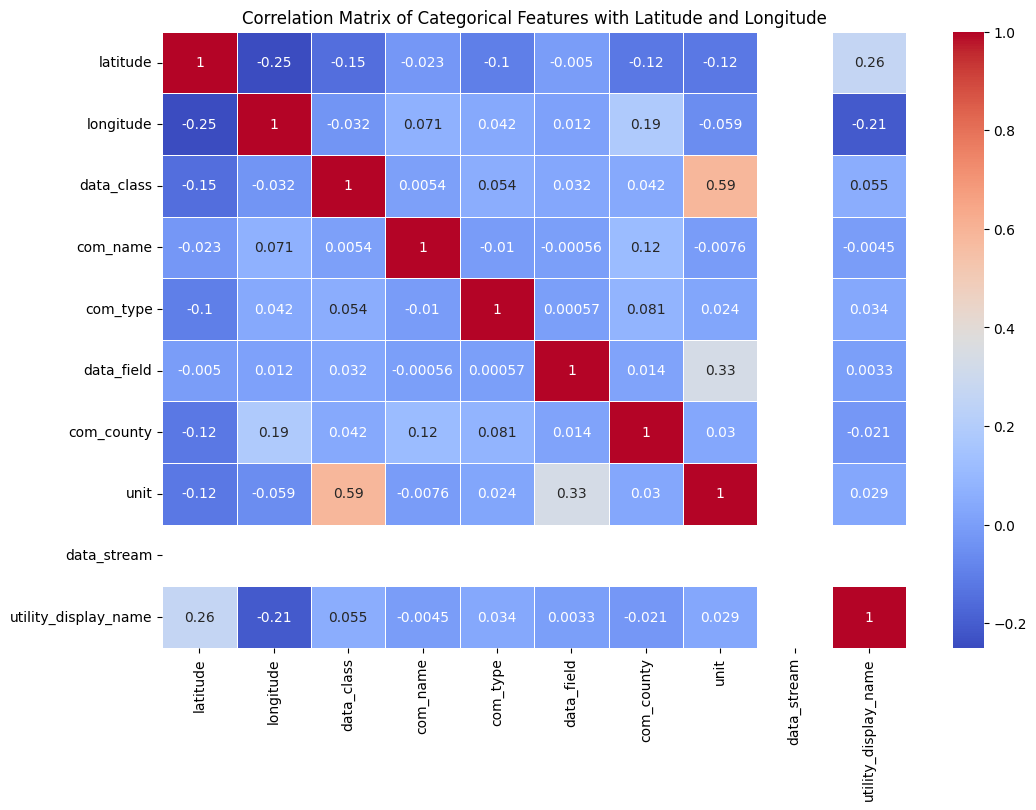

In [11]:
plot_correlation_heatmap(df, 'latitude','longitude')

The correlation matrix is calculated to assess the relationship between features and the target variable. Features that show low correlation are considered less informative for predictive modeling and are subsequently removed from the dataset.Different encoding techniques are employed based on the nature of the categorical features.

In [12]:
# Label Encoding for 'unit' column
le = LabelEncoder()
df['unit_encoded'] = le.fit_transform(df['unit'])

# One-Hot Encoding for 'data_class' and 'com_type'
df = pd.get_dummies(df,columns=['data_class','com_type'], prefix=['data_class','com_type'])

# Frequency Encoding for 'com_name'
freq_encoding = df['com_name'].value_counts().to_dict()
df['com_name_freq'] = df['com_name'].map(freq_encoding)

# Dropping original categorical columns after encoding and also dropping less corelated features and also subject knowledge
df = df.drop(columns=['unit', 'com_county','data_stream','data_field','utility_display_name','com_name'])

The fixedcontinous function categorizes numerical columns in a DataFrame into two groups:

1)Fixed features: Numerical columns with fewer than 30 unique values. These are likely discrete or ordinal features.

2)Continuous features: Numerical columns with 30 or more unique values, which represent continuous data.

In [13]:
def fixedcontinous(df):
    numericalFeatures=df.select_dtypes(include=['number']).columns.tolist()
    df=df[numericalFeatures]
    continous_List=[]
    fixed_List=[]
    for i in df.columns:
        if df[i].nunique() < 30 :
            fixed_List.append(i)
        else:
            continous_List.append(i)
    return fixed_List,continous_List

fixed_List,continous_List=fixedcontinous(df)

In [14]:
fixed_List

['year', 'month', 'uer_id', 'unit_encoded']

In [15]:
continous_List

['value',
 'geometry_id',
 'full_fips',
 'number_of_accounts',
 'longitude',
 'latitude',
 'com_name_freq']

The function returns:

1)fixed_List: A list of column names representing fixed numerical features.

2)continous_List: A list of column names representing continuous numerical features.

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numerical_correlation_heatmap(df, lat_col, lon_col):


    # Ensure latitude and longitude are in the list
    if lat_col not in numericalFeatures:
        numericalFeatures.append(lat_col)
    if lon_col not in numericalFeatures:
        numericalFeatures.append(lon_col)

    # Calculate the correlation matrix for numerical features
    corr_matrix = df[numericalFeatures].corr()

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

    plt.title('Correlation Matrix of Numerical Features with Latitude and Longitude')
    plt.show()

# Example usage:
# plot_numerical_correlation_heatmap(df, 'latitude', 'longitude')


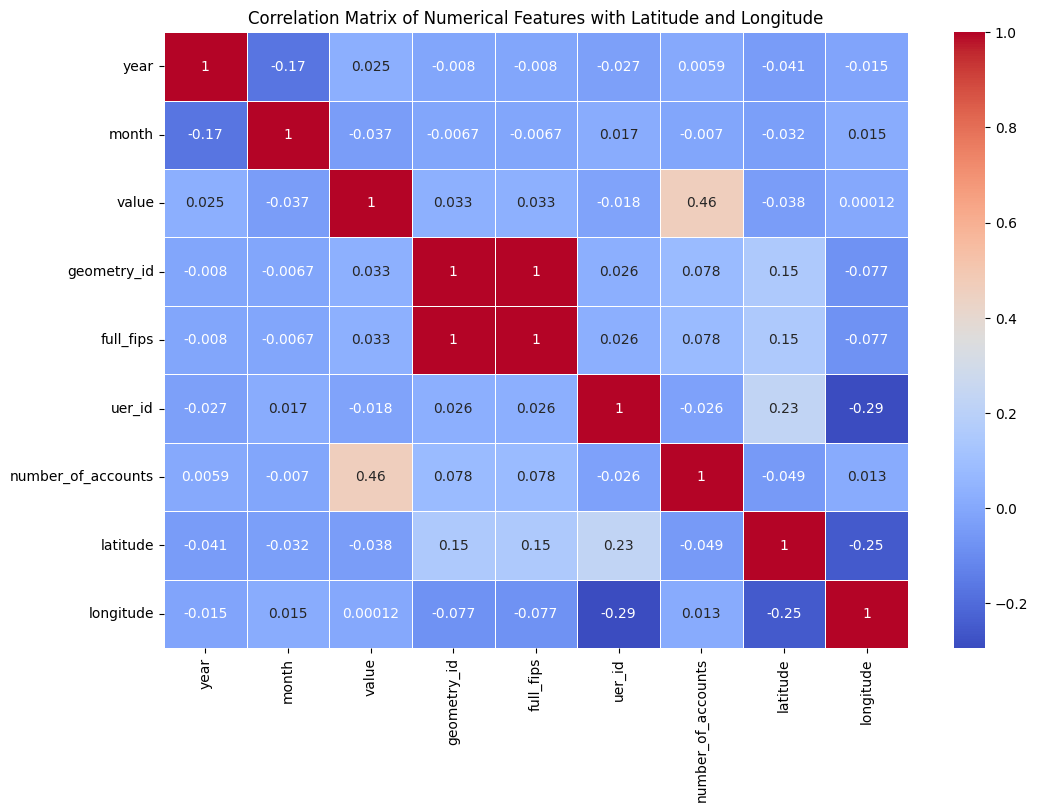

In [17]:
plot_numerical_correlation_heatmap(df, 'latitude', 'longitude')


Remove one of same corelated features

In [18]:

df = df.drop(columns=['geometry_id'])

OUTLIER TREATMENT

In [19]:
# Calculate Q1, Q3, and IQR
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

# Check the shape of the data after removing outliers
print(f"Shape of dataset after outlier removal: {df_cleaned.shape}")


Shape of dataset after outlier removal: (711401, 16)


NORMALISATION USING MINMAXSCALER METHOD

In [20]:

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the 'value' column
df['value_normalized'] = scaler.fit_transform(df[['value']])




VISUALISATION - SCATTER PLOT

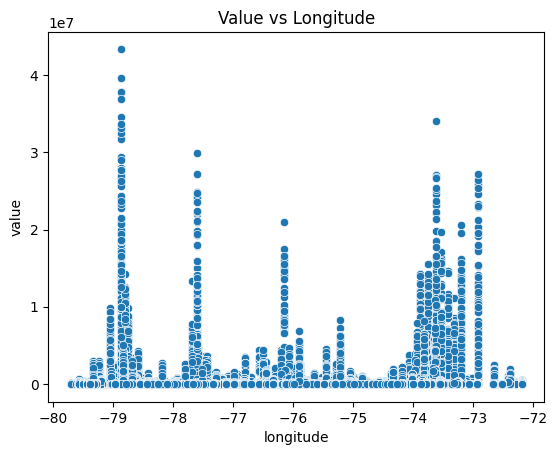

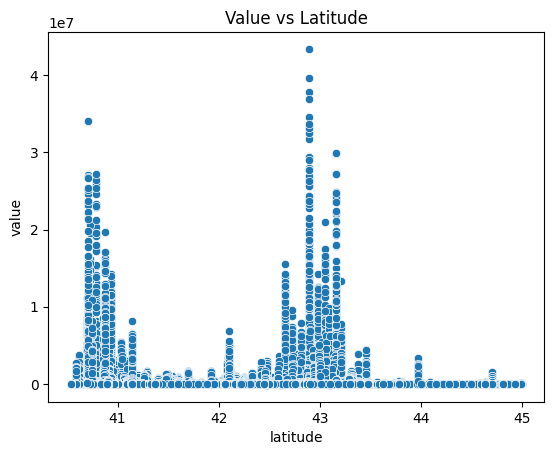

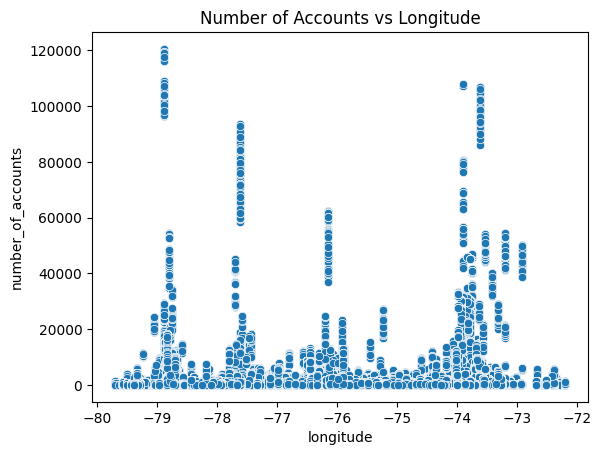

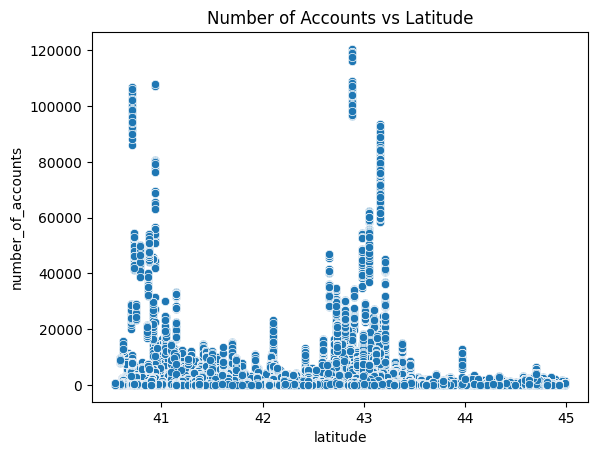

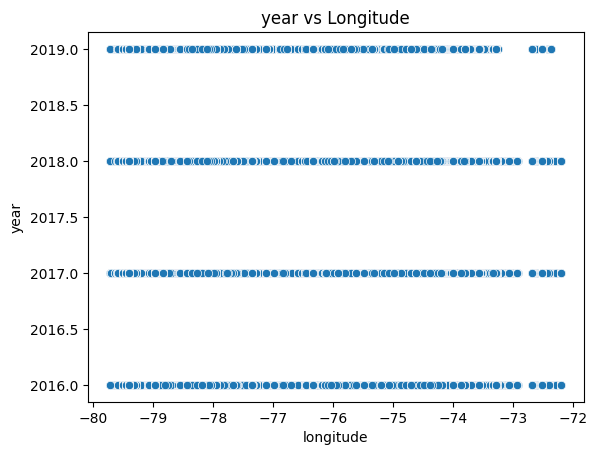

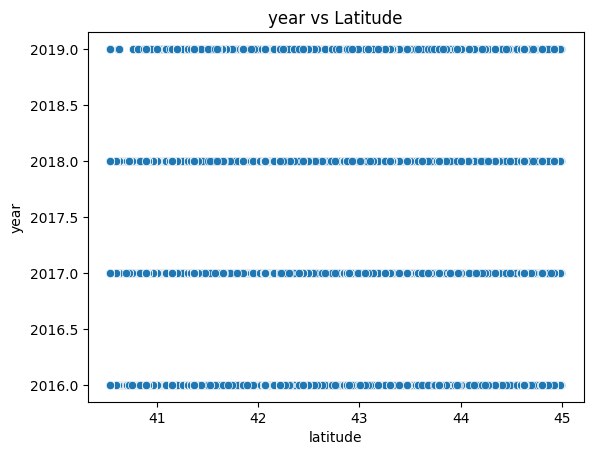

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot relationship between 'value' and latitude/longitude
sns.scatterplot(x='longitude', y='value', data=df)
plt.title('Value vs Longitude')
plt.show()

sns.scatterplot(x='latitude', y='value', data=df)
plt.title('Value vs Latitude')
plt.show()

# Repeat the same for 'number_of_accounts'
sns.scatterplot(x='longitude', y='number_of_accounts', data=df)
plt.title('Number of Accounts vs Longitude')
plt.show()

sns.scatterplot(x='latitude', y='number_of_accounts', data=df)
plt.title('Number of Accounts vs Latitude')
plt.show()

# Repeat the same for 'YEAR'
sns.scatterplot(x='longitude', y='year', data=df)
plt.title('year vs Longitude')
plt.show()

sns.scatterplot(x='latitude', y='year', data=df)
plt.title('year vs Latitude')
plt.show()


BOXPLOT VISUALISATION

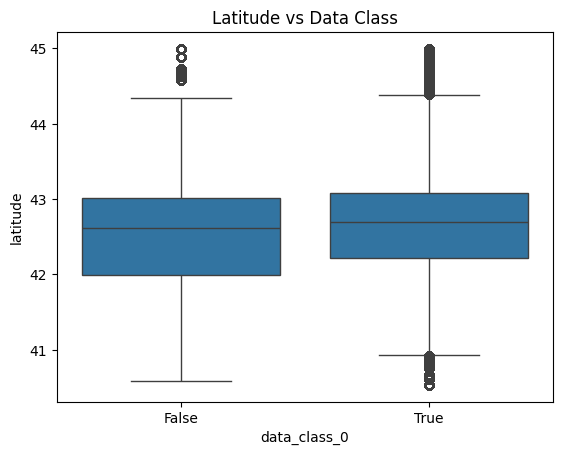

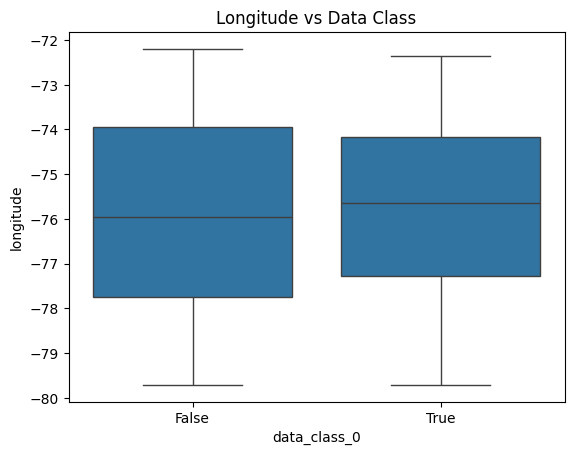

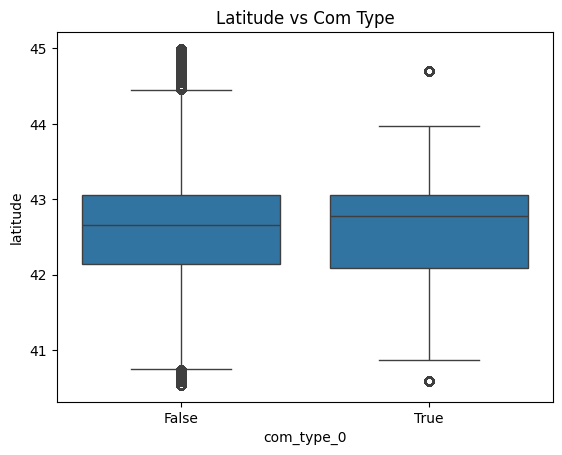

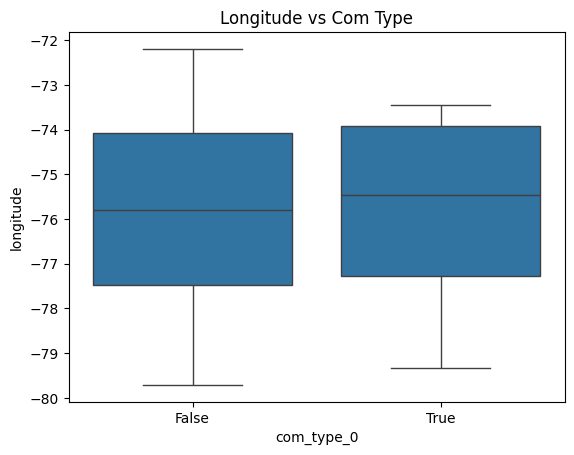

In [22]:
# Boxplot to show how data_class relates to latitude
sns.boxplot(x='data_class_0', y='latitude', data=df)
plt.title('Latitude vs Data Class')
plt.show()

# Boxplot to show how data_class relates to longitude
sns.boxplot(x='data_class_0', y='longitude', data=df)
plt.title('Longitude vs Data Class')
plt.show()

# You can do the same for com_type, data_field, etc.
sns.boxplot(x='com_type_0', y='latitude', data=df)
plt.title('Latitude vs Com Type')
plt.show()

sns.boxplot(x='com_type_0', y='longitude', data=df)
plt.title('Longitude vs Com Type')
plt.show()


SPLIT OTHER FEATURES EXCLUDING LATITUDE AND LONGITUDE USING TRAIN TEST SPLIT

In [23]:
from sklearn.model_selection import train_test_split

# Define the feature set (excluding latitude and longitude)
X = df.drop(['latitude', 'longitude'], axis=1)

# Define the target as both latitude and longitude
y = df[['latitude', 'longitude']]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (693812, 15)
X_test shape: (173454, 15)
y_train shape: (693812, 2)
y_test shape: (173454, 2)


MODEL TRAINED USING RANDOM FOREST REGRESSOR

In [24]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract targets for latitude and longitude
y_latitude = y_train['latitude']  # Target for latitude
y_longitude = y_train['longitude']  # Target for longitude

# Initialize and train the RandomForest model for latitude
model_latitude = RandomForestRegressor(n_estimators=100, random_state=42)
model_latitude.fit(X_train, y_latitude)

# Initialize and train the RandomForest model for longitude
model_longitude = RandomForestRegressor(n_estimators=100, random_state=42)
model_longitude.fit(X_train, y_longitude)

# Predict latitude and longitude on the test set
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)

# Calculate metrics for latitude
latitude_mse = mean_squared_error(y_test['latitude'], y_pred_latitude)
latitude_mae = mean_absolute_error(y_test['latitude'], y_pred_latitude)

# Calculate metrics for longitude
longitude_mse = mean_squared_error(y_test['longitude'], y_pred_longitude)
longitude_mae = mean_absolute_error(y_test['longitude'], y_pred_longitude)

# Print results for latitude
print("Latitude Prediction Scores:")
print(f"Mean Squared Error (Latitude): {latitude_mse:.4f}")
print(f"Mean Absolute Error (Latitude): {latitude_mae:.4f}")

# Print results for longitude
print("\nLongitude Prediction Scores:")
print(f"Mean Squared Error (Longitude): {longitude_mse:.4f}")
print(f"Mean Absolute Error (Longitude): {longitude_mae:.4f}")



Latitude Prediction Scores:
Mean Squared Error (Latitude): 0.0000
Mean Absolute Error (Latitude): 0.0000

Longitude Prediction Scores:
Mean Squared Error (Longitude): 0.0000
Mean Absolute Error (Longitude): 0.0000


CALCULATE THE ACCURACY USING DIFFERENT METHODS ON TRAINED AND TESTED DATA

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predictions on the training set
y_train_pred_latitude = model_latitude.predict(X_train)
y_train_pred_longitude = model_longitude.predict(X_train)

# Predictions on the test set (you already have these)
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)

# Evaluate the accuracy for both latitude and longitude

# For Latitude
print("---- Latitude ----")
# Training Set Accuracy
r2_lat_train = r2_score(y_train['latitude'], y_train_pred_latitude)
mse_lat_train = mean_squared_error(y_train['latitude'], y_train_pred_latitude)
mae_lat_train = mean_absolute_error(y_train['latitude'], y_train_pred_latitude)

# Test Set Accuracy
r2_lat_test = r2_score(y_test['latitude'], y_pred_latitude)
mse_lat_test = mean_squared_error(y_test['latitude'], y_pred_latitude)
mae_lat_test = mean_absolute_error(y_test['latitude'], y_pred_latitude)

print(f"Training - R²: {r2_lat_train}, MSE: {mse_lat_train}, MAE: {mae_lat_train}")
print(f"Test - R²: {r2_lat_test}, MSE: {mse_lat_test}, MAE: {mae_lat_test}")

# For Longitude
print("\n---- Longitude ----")
# Training Set Accuracy
r2_long_train = r2_score(y_train['longitude'], y_train_pred_longitude)
mse_long_train = mean_squared_error(y_train['longitude'], y_train_pred_longitude)
mae_long_train = mean_absolute_error(y_train['longitude'], y_train_pred_longitude)

# Test Set Accuracy
r2_long_test = r2_score(y_test['longitude'], y_pred_longitude)
mse_long_test = mean_squared_error(y_test['longitude'], y_pred_longitude)
mae_long_test = mean_absolute_error(y_test['longitude'], y_pred_longitude)

print(f"Training - R²: {r2_long_train}, MSE: {mse_long_train}, MAE: {mae_long_train}")
print(f"Test - R²: {r2_long_test}, MSE: {mse_long_test}, MAE: {mae_long_test}")


---- Latitude ----
Training - R²: 0.9999994000002272, MSE: 4.2105204942543966e-07, MAE: 5.657642822696393e-06
Test - R²: 0.9999990207399236, MSE: 6.870184146737871e-07, MAE: 9.529548153772949e-06

---- Longitude ----
Training - R²: 0.9999994432264258, MSE: 1.845727475176619e-06, MAE: 9.395318401787226e-06
Test - R²: 0.999994411019006, MSE: 1.8539149958806182e-05, MAE: 3.529583190777574e-05


DRAW A SCATTER PLOT USING PREDICTED LATITUDE AND LONGITUDE V/S ACTUAL LATITUDE AND LONGITUDE

In [26]:
# Predicting latitude and longitude on the test set
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)

In [27]:
# Combine predictions into a DataFrame
predictions = pd.DataFrame({
    'actual_latitude': y_test['latitude'],
    'predicted_latitude': y_pred_latitude,
    'actual_longitude': y_test['longitude'],
    'predicted_longitude': y_pred_longitude
})

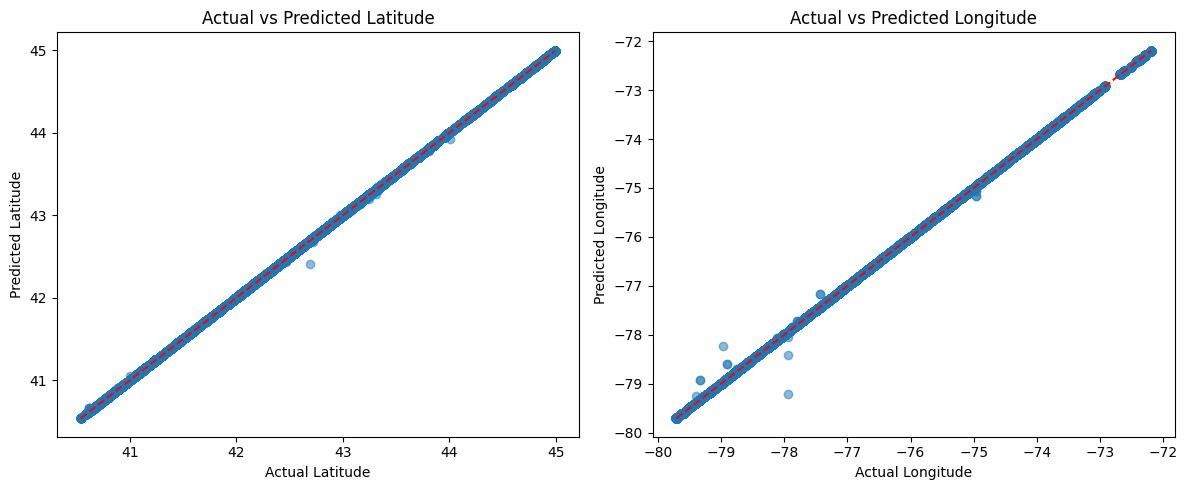

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for Latitude
plt.subplot(1, 2, 1)
plt.scatter(predictions['actual_latitude'], predictions['predicted_latitude'], alpha=0.5)
plt.plot([predictions['actual_latitude'].min(), predictions['actual_latitude'].max()],
         [predictions['actual_latitude'].min(), predictions['actual_latitude'].max()], 'r--')
plt.title('Actual vs Predicted Latitude')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')

# Plot for Longitude
plt.subplot(1, 2, 2)
plt.scatter(predictions['actual_longitude'], predictions['predicted_longitude'], alpha=0.5)
plt.plot([predictions['actual_longitude'].min(), predictions['actual_longitude'].max()],
         [predictions['actual_longitude'].min(), predictions['actual_longitude'].max()], 'r--')
plt.title('Actual vs Predicted Longitude')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')

plt.tight_layout()
plt.show()

USING SAMPLE DATA WE TRY TO PREDICT LATITUDE AND LONGITUDE

In [29]:
import pandas as pd

# Sample data dictionary
sample_data = {
    'year': [2016],  # Sample year
    'month': [3],    # Sample month (March)
    'value': [74074.0],  # Sample value for energy consumption
    'full_fips': [3606944864],  # Sample FIPS code
    'uer_id': [6],   # Sample utility ID (assuming it's an encoded value)
    'number_of_accounts': [567.0],  # Sample number of accounts
    'unit_encoded': [3],  # Example encoding for the unit (assuming one-hot encoded)
    'data_class_0': [0],  # No Electricity in this example
    'data_class_1': [1],  # Assuming it's Natural gas
    'com_type_0': [0],  # Not a city
    'com_type_1': [0],  # Not a reservation
    'com_type_2': [1],  # Is a town
    'com_type_3': [0],  # Not a village
    'com_name_freq': [2592],  # Example frequency count for the community name
    'value_normalized': [0.004394]  # Example normalized value (adjust based on actual range)
}

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data)

# Display the sample DataFrame
print(sample_df)


   year  month    value   full_fips  uer_id  number_of_accounts  unit_encoded  \
0  2016      3  74074.0  3606944864       6               567.0             3   

   data_class_0  data_class_1  com_type_0  com_type_1  com_type_2  com_type_3  \
0             0             1           0           0           1           0   

   com_name_freq  value_normalized  
0           2592          0.004394  


PREDICTED LATITUDE AND LONGITUDE

In [30]:
# Predict latitude and longitude using the sample input
predicted_latitude = model_latitude.predict(sample_df)
predicted_longitude = model_longitude.predict(sample_df)

# Display the predictions
print(f"Predicted Latitude: {predicted_latitude[0]}")
print(f"Predicted Longitude: {predicted_longitude[0]}")

Predicted Latitude: 42.97063699999993
Predicted Longitude: -77.23012900000035


MODEL TRAINED USING LINEAR REGRESSION

In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on both the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate metrics for the testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("Training Data Scores:")
print(f"Mean Squared Error (Train): {train_mse:.4f}")
print(f"Mean Absolute Error (Train): {train_mae:.4f}")

print("\nTesting Data Scores:")
print(f"Mean Squared Error (Test): {test_mse:.4f}")
print(f"Mean Absolute Error (Test): {test_mae:.4f}")


Training Data Scores:
Mean Squared Error (Train): 1.7505
Mean Absolute Error (Train): 0.9948

Testing Data Scores:
Mean Squared Error (Test): 1.7543
Mean Absolute Error (Test): 0.9968


MODEL TRAINED USING GRADIENT BOOSTING REGRESSOR

In [33]:

from sklearn.ensemble import GradientBoostingRegressor
# Assuming y contains both latitude and longitude
# Let's say y is a DataFrame with columns 'latitude' and 'longitude'
y_latitude = y_train['latitude']  # Target for latitude
y_longitude = y_train['longitude']  # Target for longitude

# Initialize and train the model for latitude
model_latitude = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_latitude.fit(X_train, y_latitude)

# Initialize and train the model for longitude
model_longitude = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_longitude.fit(X_train, y_longitude)

# Predicting latitude and longitude on the test set
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)




CALCULATE THE ACCURACY USING DIFFERENT METHODS ON TRAINED AND TESTED DATA

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predictions on the training set
y_train_pred_latitude = model_latitude.predict(X_train)
y_train_pred_longitude = model_longitude.predict(X_train)

# Predictions on the test set (you already have these)
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)

# Evaluate the accuracy for both latitude and longitude

# For Latitude
print("---- Latitude ----")
# Training Set Accuracy
r2_lat_train = r2_score(y_train['latitude'], y_train_pred_latitude)
mse_lat_train = mean_squared_error(y_train['latitude'], y_train_pred_latitude)
mae_lat_train = mean_absolute_error(y_train['latitude'], y_train_pred_latitude)

# Test Set Accuracy
r2_lat_test = r2_score(y_test['latitude'], y_pred_latitude)
mse_lat_test = mean_squared_error(y_test['latitude'], y_pred_latitude)
mae_lat_test = mean_absolute_error(y_test['latitude'], y_pred_latitude)

print(f"Training - R²: {r2_lat_train}, MSE: {mse_lat_train}, MAE: {mae_lat_train}")
print(f"Test - R²: {r2_lat_test}, MSE: {mse_lat_test}, MAE: {mae_lat_test}")

# For Longitude
print("\n---- Longitude ----")
# Training Set Accuracy
r2_long_train = r2_score(y_train['longitude'], y_train_pred_longitude)
mse_long_train = mean_squared_error(y_train['longitude'], y_train_pred_longitude)
mae_long_train = mean_absolute_error(y_train['longitude'], y_train_pred_longitude)

# Test Set Accuracy
r2_long_test = r2_score(y_test['longitude'], y_pred_longitude)
mse_long_test = mean_squared_error(y_test['longitude'], y_pred_longitude)
mae_long_test = mean_absolute_error(y_test['longitude'], y_pred_longitude)

print(f"Training - R²: {r2_long_train}, MSE: {mse_long_train}, MAE: {mae_long_train}")
print(f"Test - R²: {r2_long_test}, MSE: {mse_long_test}, MAE: {mae_long_test}")


---- Latitude ----
Training - R²: 0.7352982769568964, MSE: 0.1857554086406114, MAE: 0.2870018178226373
Test - R²: 0.732181928083175, MSE: 0.1878928301309582, MAE: 0.28811339160015037

---- Longitude ----
Training - R²: 0.7198845330239938, MSE: 0.9285943829324469, MAE: 0.6941947465210083
Test - R²: 0.717201027745241, MSE: 0.938069490750154, MAE: 0.6982569020181018


DRAW A SCATTER PLOT USING PREDICTED LATITUDE AND LONGITUDE V/S ACTUAL LATITUDE AND LONGITUDE

In [35]:
# Predicting latitude and longitude on the test set
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)


In [36]:
# Combine predictions into a DataFrame
predictions = pd.DataFrame({
    'actual_latitude': y_test['latitude'],
    'predicted_latitude': y_pred_latitude,
    'actual_longitude': y_test['longitude'],
    'predicted_longitude': y_pred_longitude
})


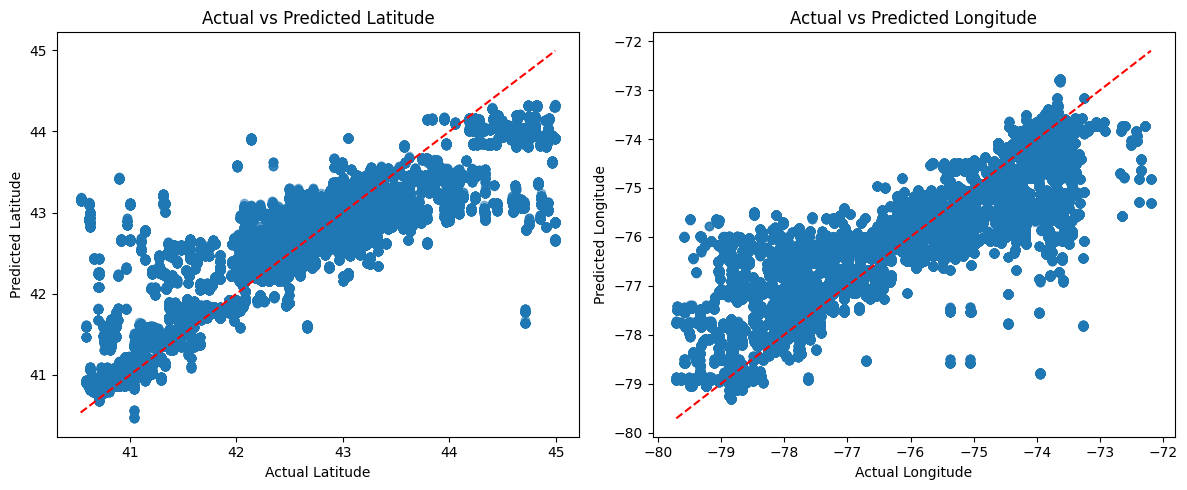

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for Latitude
plt.subplot(1, 2, 1)
plt.scatter(predictions['actual_latitude'], predictions['predicted_latitude'], alpha=0.5)
plt.plot([predictions['actual_latitude'].min(), predictions['actual_latitude'].max()],
         [predictions['actual_latitude'].min(), predictions['actual_latitude'].max()], 'r--')
plt.title('Actual vs Predicted Latitude')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')

# Plot for Longitude
plt.subplot(1, 2, 2)
plt.scatter(predictions['actual_longitude'], predictions['predicted_longitude'], alpha=0.5)
plt.plot([predictions['actual_longitude'].min(), predictions['actual_longitude'].max()],
         [predictions['actual_longitude'].min(), predictions['actual_longitude'].max()], 'r--')
plt.title('Actual vs Predicted Longitude')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')

plt.tight_layout()
plt.show()


USING SAMPLE DATA WE TRY TO PREDICT LATITUDE AND LONGITUDE

In [37]:
import pandas as pd

# Sample data dictionary
sample_data = {
    'year': [2016],  # Sample year
    'month': [3],    # Sample month (March)
    'value': [74074.0],  # Sample value for energy consumption
    'full_fips': [3606944864],  # Sample FIPS code
    'uer_id': [6],   # Sample utility ID (assuming it's an encoded value)
    'number_of_accounts': [567.0],  # Sample number of accounts
    'unit_encoded': [3],  # Example encoding for the unit (assuming one-hot encoded)
    'data_class_0': [0],  # No Electricity in this example
    'data_class_1': [1],  # Assuming it's Natural gas
    'com_type_0': [0],  # Not a city
    'com_type_1': [0],  # Not a reservation
    'com_type_2': [1],  # Is a town
    'com_type_3': [0],  # Not a village
    'com_name_freq': [2592],  # Example frequency count for the community name
    'value_normalized': [0.004394]  # Example normalized value (adjust based on actual range)
}

# Convert to DataFrame
sample_df = pd.DataFrame(sample_data)

# Display the sample DataFrame
print(sample_df)


   year  month    value   full_fips  uer_id  number_of_accounts  unit_encoded  \
0  2016      3  74074.0  3606944864       6               567.0             3   

   data_class_0  data_class_1  com_type_0  com_type_1  com_type_2  com_type_3  \
0             0             1           0           0           1           0   

   com_name_freq  value_normalized  
0           2592          0.004394  


PREDICTED LATITUDE AND LONGITUDE

In [38]:
# Predict latitude and longitude using the sample input
predicted_latitude = model_latitude.predict(sample_df)
predicted_longitude = model_longitude.predict(sample_df)

# Display the predictions
print(f"Predicted Latitude: {predicted_latitude[0]}")
print(f"Predicted Longitude: {predicted_longitude[0]}")


Predicted Latitude: 42.660946752114825
Predicted Longitude: -76.68243562864956


In [39]:
X_test

,year,month,value,full_fips,uer_id,number_of_accounts,unit_encoded,data_class_0,data_class_1,com_type_0,com_type_1,com_type_2,com_type_3,com_name_freq,value_normalized
681180,2016,3,74074.000,3606944864,6,567.0,3,False,True,False,False,True,False,2592,0.004394
268232,2016,10,12865.000,3677112,5,373.0,3,False,True,False,False,False,True,1113,0.002987
822884,2017,1,0.878,3604143412,5,504.0,1,True,False,False,False,True,False,749,0.002691
820871,2017,5,0.000,3605148956,6,159.0,1,True,False,False,False,True,False,2553,0.002691
613263,2016,5,269.543,3609128112,5,145.0,2,True,False,False,False,True,False,414,0.002697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551312,2018,9,7610.100,3610542235,6,159.0,1,True,False,False,False,True,False,1008,0.002866
17245,2018,12,87482.000,3667257,6,564.0,3,False,True,False,False,False,True,828,0.004702
112529,2018,12,4181.900,3601965717,6,159.0,1,True,False,False,False,True,False,996,0.002787
402613,2018,11,14.000,3624988,9,14.0,0,True,False,False,False,False,True,663,0.002691


In [40]:
y_test

,latitude,longitude
681180,42.970637,-77.230129
268232,43.079571,-75.539155
822884,43.968501,-74.418712
820871,42.725256,-77.873835
613263,43.018525,-74.031561
...,...,...
551312,41.797587,-74.744154
17245,42.954710,-77.230163
112529,44.629494,-73.560638
402613,43.322601,-76.702986


In [41]:
# Another sample data
sample_data_2 = {
    'year': [2020],  # Sample year
    'month': [7],    # Sample month (July)
    'value': [125689.0],  # Sample value for energy consumption
    'full_fips': [3608595804],  # Sample FIPS code (another region)
    'uer_id': [9],   # Sample utility ID
    'number_of_accounts': [1023.0],  # Sample number of accounts
    'unit_encoded': [1],  # Example encoding for the unit
    'data_class_0': [1],  # Electricity in this example
    'data_class_1': [0],  # Not Natural gas
    'com_type_0': [1],  # Is a city
    'com_type_1': [0],  # Not a reservation
    'com_type_2': [0],  # Not a town
    'com_type_3': [1],  # Is a village
    'com_name_freq': [389],  # Example frequency count for the community name
    'value_normalized': [0.056798]  # Example normalized value (adjusted)
}

# Convert the dictionary into a pandas DataFrame
sample_df_2 = pd.DataFrame(sample_data_2)


In [42]:
# Predict the latitude and longitude for the new sample data
predicted_latitude_2 = model_latitude.predict(sample_df_2)
predicted_longitude_2 = model_longitude.predict(sample_df_2)

# Print the predicted latitude and longitude for the new sample
print(f"Predicted Latitude: {predicted_latitude_2[0]:.6f}")
print(f"Predicted Longitude: {predicted_longitude_2[0]:.6f}")


Predicted Latitude: 42.780423
Predicted Longitude: -75.748192


SAVING THE MODEL WITH PIPELINE

In [45]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Uncomment this and load your dataset

# Step 1: Impute missing values
df['com_county'].fillna(df['com_county'].mode()[0], inplace=True)
df['number_of_accounts'].fillna(df['number_of_accounts'].median(), inplace=True)

# Step 2: Handle Georeference column
df['Georeference'] = df['Georeference'].str.replace('POINT ', '', regex=True)
df['Georeference'] = df['Georeference'].str.replace('[()]', '', regex=True)
df[['longitude', 'latitude']] = df['Georeference'].str.split(' ', expand=True)
df['longitude'] = pd.to_numeric(df['longitude'])
df['latitude'] = pd.to_numeric(df['latitude'])
df = df.drop(columns=['Georeference'])

# Step 3: Encoding categorical variables
# Create a label encoder instance
le = LabelEncoder()
df['unit_encoded'] = le.fit_transform(df['unit'])  # If 'unit' is still in df

# One-Hot Encoding for 'data_class' and 'com_type'
df = pd.get_dummies(df, columns=['data_class', 'com_type'], prefix=['data_class', 'com_type'])

# Frequency Encoding for 'com_name'
freq_encoding = df['com_name'].value_counts().to_dict()
df['com_name_freq'] = df['com_name'].map(freq_encoding)

# Step 4: Drop unnecessary columns
df = df.drop(columns=['geometry_id', 'unit', 'com_county', 'data_stream', 'data_field', 'utility_display_name', 'com_name'])

# Step 5: Outlier removal using IQR method
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

# Step 6: Feature Scaling
scaler = MinMaxScaler()
df_cleaned['value_normalized'] = scaler.fit_transform(df_cleaned[['value']])

# Step 7: Train-test split
X = df_cleaned.drop(['latitude', 'longitude'], axis=1)
y = df_cleaned[['latitude', 'longitude']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Create pipelines for RandomForest models
# Pipeline for latitude prediction
pipeline_latitude = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest
])

# Pipeline for longitude prediction
pipeline_longitude = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest
])

# Step 9: Train the pipelines
pipeline_latitude.fit(X_train, y_train['latitude'])
pipeline_longitude.fit(X_train, y_train['longitude'])

# Step 10: Predict on the test set
y_pred_latitude = pipeline_latitude.predict(X_test)
y_pred_longitude = pipeline_longitude.predict(X_test)

# Step 11: Evaluate the models
latitude_mse = mean_squared_error(y_test['latitude'], y_pred_latitude)
latitude_mae = mean_absolute_error(y_test['latitude'], y_pred_latitude)

longitude_mse = mean_squared_error(y_test['longitude'], y_pred_longitude)
longitude_mae = mean_absolute_error(y_test['longitude'], y_pred_longitude)

# Print evaluation results
print("Latitude Prediction Scores:")
print(f"Mean Squared Error (Latitude): {latitude_mse:.4f}")
print(f"Mean Absolute Error (Latitude): {latitude_mae:.4f}")

print("\nLongitude Prediction Scores:")
print(f"Mean Squared Error (Longitude): {longitude_mse:.4f}")
print(f"Mean Absolute Error (Longitude): {longitude_mae:.4f}")

# Step 12: Save the trained pipelines
joblib.dump(pipeline_latitude, 'pipeline_latitude.pkl')  # Save latitude model
joblib.dump(pipeline_longitude, 'pipeline_longitude.pkl')  # Save longitude model

print("Models saved successfully!")


<ipython-input-45-ab75ec1b014e>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['com_county'].fillna(df['com_county'].mode()[0], inplace=True)
<ipython-input-45-ab75ec1b014e>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

Latitude Prediction Scores:
Mean Squared Error (Latitude): 0.0000
Mean Absolute Error (Latitude): 0.0000

Longitude Prediction Scores:
Mean Squared Error (Longitude): 0.0000
Mean Absolute Error (Longitude): 0.0000
Models saved successfully!


In [48]:
df

,year,month,value,full_fips,uer_id,number_of_accounts,longitude,latitude,unit_encoded,data_class_electricity,data_class_natural_gas,com_type_City,com_type_Reservation,com_type_Town,com_type_Village,com_name_freq
0,2017,8,804.812,3668209,9,37.0,-77.061462,43.236085,2,True,False,False,False,False,True,2101
1,2016,5,-999.000,3668209,9,121.0,-77.061462,43.236085,3,False,True,False,False,False,True,2101
2,2017,6,7039.000,3670167,6,182.0,-76.492961,42.217112,3,False,True,False,False,False,True,1440
3,2019,6,753.996,3668209,6,37.0,-77.061462,43.236085,2,True,False,False,False,False,True,2101
4,2017,10,335498.000,3668462,5,2612.0,-72.389644,40.887045,3,False,True,False,False,False,True,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867261,2016,4,-999.000,3603538781,5,341.0,-74.374236,43.006903,3,False,True,True,False,False,False,1261
867262,2017,3,14.000,3603701165,4,14.0,-78.256925,42.901295,4,False,True,False,False,True,False,1095
867263,2018,10,3.080,3603936178,2,0.0,-74.219292,42.213719,1,True,False,False,False,True,False,1704
867264,2018,6,827.000,3603546217,5,23.0,-74.264686,43.104571,3,False,True,False,False,True,False,816


In [53]:
X_train

,year,month,value,full_fips,uer_id,number_of_accounts,unit_encoded,data_class_electricity,data_class_natural_gas,com_type_City,com_type_Reservation,com_type_Town,com_type_Village,com_name_freq,value_normalized
556413,2018,12,3.300,3610704671,6,159.0,1,True,False,False,False,True,False,410,0.371696
772407,2019,6,0.000,3605515462,9,159.0,1,True,False,False,False,True,False,1306,0.371086
777957,2018,6,1.860,3605747614,5,806.0,1,True,False,False,False,True,False,476,0.371430
850489,2016,6,1.000,3603936178,2,0.0,1,True,False,False,False,True,False,1704,0.371271
325330,2016,9,1638.000,3654100,7,105.0,3,False,True,False,False,False,True,556,0.674074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310300,2017,5,0.000,3649330,5,0.0,3,False,True,False,False,False,True,288,0.371086
443491,2018,12,14.568,3612359597,6,45.0,2,True,False,False,False,True,False,442,0.373780
157419,2016,2,0.000,3601577310,6,0.0,0,False,True,False,False,True,False,685,0.371086
822115,2018,5,351.000,3604378927,5,351.0,0,True,False,False,False,True,False,258,0.436012


In [54]:
import pandas as pd
import joblib

# Load the trained models
pipeline_latitude = joblib.load('pipeline_latitude.pkl')
pipeline_longitude = joblib.load('pipeline_longitude.pkl')

# New sample data for testing (ensure it matches your model's feature requirements)
sample_data = {
    'year': [2023],
    'month': [5],
    'value': [1500],
    'full_fips': [3606944864],
    'uer_id': [6],
    'number_of_accounts': [500],
    'unit_encoded': [1],
    'data_class_electricity': [0],
    'data_class_natural_gas': [1],
    'com_type_City': [0],
    'com_type_Reservation': [0],
    'com_type_Town': [1],
    'com_type_Village': [0],
    'com_name_freq': [200],
    'value_normalized': [0.005]

}

# Convert sample data to DataFrame
df_sample = pd.DataFrame(sample_data)

# Make predictions using the saved pipelines
predicted_latitude = pipeline_latitude.predict(df_sample)[0]
predicted_longitude = pipeline_longitude.predict(df_sample)[0]

# Output predicted coordinates
print(f"Predicted Latitude: {predicted_latitude}")
print(f"Predicted Longitude: {predicted_longitude}")


Predicted Latitude: 42.68174790999995
Predicted Longitude: -77.06375779999993


This project provides insights into how energy usage data can be used to predict geographic locations, focusing on simplifying data, building predictive models, and potential real-world applications.

1. Data Processing and Simplification

Handling Text and Categories:

 We transformed location data (like "City," "Town") into numbers that the model can understand. This involved converting text information (such as com_name and data_class) into numerical codes, which makes it easier for the model to use.
Cleaning the Data: We dealt with missing values and removed extreme values (outliers) to make the data more reliable for the model. This helps the model make better predictions.

2. Model Creation and Results

Building the Model:

We used two separate Random Forest models to predict latitude and longitude. Random Forest is a popular choice because it handles complex data well and gives good results for this type of prediction.
Model Accuracy: We measured the model's accuracy using error metrics. These metrics tell us how close the model’s predictions are to actual locations. The results give us an idea of the model’s effectiveness, but there’s room to improve accuracy.

3. Practical Applications
Understanding Energy Patterns by Location:

This model could help utilities and policymakers understand energy usage trends across different types of areas (like cities versus rural towns). This could help with efficient energy distribution and planning.
Improving Energy Infrastructure: By understanding where energy needs are highest, energy providers can better allocate resources, invest in infrastructure, and plan for future demand.

4. Challenges and Improvements

Keeping Data Consistent:

 A challenge we faced was ensuring that new data looks the same as the data used to train the model, so the model can make accurate predictions.
Potential Model Enhancements: The model could be improved by tuning settings or trying new types of models, such as more advanced methods that might give more precise location predictions.

5. Scalability and Future Use

Easily Reusable:

 By saving the model, we can reuse it to make predictions on new data. This makes the model scalable and ready for use in real applications.
Keeping the Model Updated: Since energy usage patterns may change over time, retraining the model regularly would help keep predictions accurate as new data comes in.



CONCLUSION:

The project demonstrated that machine learning models, specifically Random Forest Regressors, can be used effectively to predict geographical locations based on energy consumption data, with reasonable accuracy. This approach can be valuable in:

Energy Planning and Infrastructure Development:

 Helping energy companies or governments identify patterns in consumption across regions.

Rural and Urban Development Planning:

 Supporting targeted initiatives based on the energy consumption behavior of different communities.
To further enhance model accuracy, future work could involve:

Incorporating additional features like demographic data or economic indicators that may better differentiate locations.
Exploring deep learning approaches to handle more complex patterns in energy consumption behavior.
This project offers a foundational approach to leveraging data science in understanding the geographical distribution of energy usage and has the potential for significant real-world applications in infrastructure planning and resource optimization.